# SQL Query Composition

This notebook builds on previous notebooks, where you've seen relative simple SQL queries (queries with a single `SELECT` statement to retrieve and analyze BigQuery data). However, BigQuery allows you to use nested queries to create complex queries that successively filter or slice/dice results, or perform joins in a single query issued to the service. Constructing these queries can often be much simpler when done step-by-step.

This notebook introduces a pattern for developing queries independently and stitching them together toward a final solution.

## Scenario

This notebook will build on the HTTP logs dataset like other samples you have seen. The goal is to build a latency distribution curve of requests. This helps visualize the latency pattern of the web server.

**Preface on Notebook Content**

Query composition through step-by-step building is intrinsically iterative, while the notebook here represents a snapshot of the final state. As such each step of the iteration is broken out into separate sections, even though its unlikely you'll do the same in a real task.

In [1]:
import gcp.bigquery as bq

# Step 1 - Inspecting Latencies

The first step is to get an initial slice of the data we're working with with a very basic query.

In [2]:
%%sql
SELECT latency FROM [cloud-datalab-samples:httplogs.logs_20140615] WHERE endpoint = 'Recent' LIMIT 10

(rows: 10, time: 0.8s, 10MB processed, job: job_nVYoegbrUJ3ebWhHa_JeXdxJBfY)

In [3]:
%%sql
SELECT MIN(latency) AS min, MAX(latency) AS max, COUNT(latency) AS count
FROM [cloud-datalab-samples:httplogs.logs_20140615]
WHERE endpoint = 'Recent'

(rows: 1, time: 1.1s, 10MB processed, job: job_54Z1g1rk3_j9jo1WaTsYrKLeYZA)

# Step 2 - Bucketing Latencies

Clearly latencies are discrete numbers (milliseconds) over a fairly wide range. One way to deal with this is to bucket them into groups.

In [4]:
%%sql --module latency
SELECT INTEGER(latency / 25) * 25 AS latency, COUNT(latency) AS requests
FROM [cloud-datalab-samples:httplogs.logs_20140615]
WHERE endpoint = 'Recent'
GROUP BY latency
ORDER BY latency

In [5]:
%bigquery execute --query latency

(rows: 23, time: 0.9s, cached, job: job_amOfK88wFVIK7Gx1nEFPeZFKEJ4)

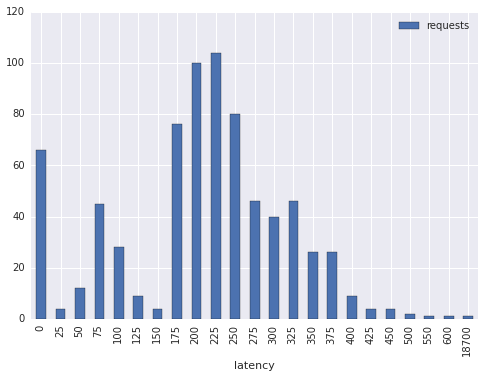

In [6]:
bq.Query(latency).to_dataframe().set_index('latency').plot(kind='bar')

# Step 3 - Latency Distribution

In this step, we want to determine the percentage of requests that fall within each bucket. In order to compute percentages, we also need to issue a count query, determine count and use the buckets along with counts to produce percentage values.

In [7]:
%%sql --module latency

DEFINE QUERY buckets
  SELECT INTEGER(latency / 25) * 25 AS latency, COUNT(latency) AS requests
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
  WHERE endpoint = 'Recent'
  GROUP BY latency
  ORDER BY latency

DEFINE QUERY stats
  SELECT COUNT(latency) AS total
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
  WHERE endpoint = 'Recent'

SELECT bucket.latency AS latency,
       bucket.requests AS requests,
       bucket.requests * 100 / stats.total AS percent
FROM $buckets AS bucket CROSS JOIN $stats AS stats
ORDER BY latency

Notice that the first query was declared with a name `buckets`, the second with a name `stats` and these were referenced in the third query as `$buckets` and `$stats` - the same parameter syntax that you've seen earlier, that allows you to parameterize queries to pass in Python variables.

The third query was left as anonymous, and is treated as the _main_ query within the SQL module named `latency`. We can inspect the fully composed SQL represented by the module by creating a `Query` object, and printing its `sql` property.

In [8]:
latency_distribution = bq.Query(latency)
print latency_distribution.sql

SELECT bucket.latency AS latency,
       bucket.requests AS requests,
       bucket.requests * 100 / stats.total AS percent
FROM (SELECT INTEGER(latency / 25) * 25 AS latency, COUNT(latency) AS requests
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
  WHERE endpoint = 'Recent'
  GROUP BY latency
  ORDER BY latency) AS bucket CROSS JOIN (SELECT COUNT(latency) AS total
  FROM [cloud-datalab-samples:httplogs.logs_20140615]
  WHERE endpoint = 'Recent') AS stats
ORDER BY latency


Notice that the `buckets` and `stats` queries have been inlined as nested queries, and used in a `JOIN`. The resulting SQL represents a single query that is issued and executed in BigQuery.

In [9]:
latency_distribution.results()

(rows: 23, time: 1.5s, 10MB processed, job: job_kDH6G8C8I8V3T1PtJwXrDngZk-c)

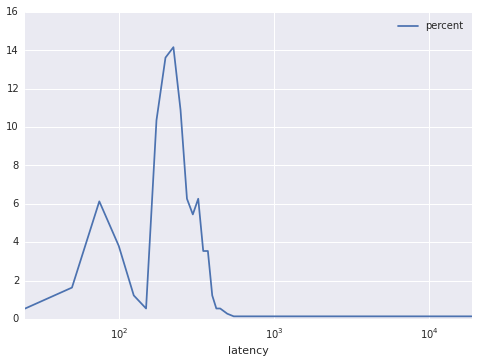

In [10]:
latency_distribution.to_dataframe().drop(['requests'], axis = 1).set_index('latency').plot(logx = True)

# Looking Ahead

Composing queries one step at a time, and validating the results along the way by either executing or sampling indermediate queries allows you to build sophisticated queries while containing the complexity.

Check out some of the BigQuery samples for more examples.